<a href="https://colab.research.google.com/github/ykitaguchi77/YOLACT_Mobius/blob/main/Mobius2label.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mobius2label**

Mobiusのカラーマスク→ YOLOv8 instance trainingトレーニング用の座標に

研究室配属 鈴木くんより

In [ ]:
#@title #ライブラリのインストール
#@markdown [shift]+[Enter]を押して起動してください
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import json
from tqdm import tqdm  # tqdmをインポート
import os
import matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title #ディレクトリと座標の個数
#@markdown 指定を終えてから、[shift]+[Enter]を押して起動してください。
#@markdown <br> 学習に適切な個数が分からなかったので、変更できるようにしました。

# 入力ディレクトリと出力ディレクトリを指定してください
input_dir = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/Masks/1"
output_dir = "/content"

# eyelid, iris, pupilごとに座標の個数を指定してください。
num_points_eyelid = 24
num_points_iris = 16
num_points_pupil = 12

In [ ]:
#@title #Mobius to label起動
#@markdown 　[shift]+[Enter]を押して起動してください。
#@markdown　<br>うまくいっていないラベルも存在するので、目視で確認して除外すべきかもしれません。
def create_mask(image, color):
    return np.all(image == color, axis=-1)

def apply_mask(image, mask):
    return np.where(mask, 255, 0)

def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list

def create_custom_output(points_list_blue, points_list_blue_green, points_list_all_colors, img_width, img_height, output_file):
    with open(output_file, 'w') as f:
        # 0: eyelid
        f.write("0 ")
        for point in points_list_all_colors[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x} {y} ")
        f.write("\n")

        # 1: iris
        f.write("1 ")
        for point in points_list_blue_green[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x} {y} ")
        f.write("\n")

        # 2: pupil
        f.write("2 ")
        for point in points_list_blue[0]:
            x = point[0] / img_width
            y = point[1] / img_height
            f.write(f"{x} {y} ")
        f.write("\n")

def process_image(mask_file, output_dir, num_points_eyelid, num_points_iris, num_points_pupil):
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    # 各ラベルごとに異なる個数の座標を抽出
    points_list_blue = extract_contours(img_blue, num_points_pupil)
    points_list_blue_green = extract_contours(img_blue_green, num_points_iris)
    points_list_all_colors = extract_contours(img_all_colors, num_points_eyelid)

    # 出力先ディレクトリとファイル名を設定
    base_name = os.path.splitext(os.path.basename(mask_file))[0]
    output_file = os.path.join(output_dir, base_name + ".txt")

    # カスタム出力
    create_custom_output(points_list_blue, points_list_blue_green, points_list_all_colors, img_width, img_height, output_file)

    # 書き換え部分
    x_eyelid = [point[0] for point in points_list_all_colors[0]]
    y_eyelid = [point[1] for point in points_list_all_colors[0]]

    x_iris = [point[0] for point in points_list_blue_green[0]]
    y_iris = [point[1] for point in points_list_blue_green[0]]

    x_pupil = [point[0] for point in points_list_blue[0]]
    y_pupil = [point[1] for point in points_list_blue[0]]

    # 元の画像を読み込む
    img_path = mask_file.replace("Masks", "Images").replace(".png", ".jpg")
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

    # プロット作成
    plt.figure(figsize=(12, 6))

    # 左側に元の画像を表示
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(base_name)  # ファイル名をタイトルに設定

    # 右側に散布図を表示
    plt.subplot(1, 2, 2)
    plt.scatter(x_eyelid, y_eyelid, label='eyelid', color='blue')
    plt.scatter(x_iris, y_iris, label='iris', color='green')
    plt.scatter(x_pupil, y_pupil, label='pupil', color='red')
    plt.title("Contours")  # 輪郭

    # 軸を画像の大きさに合わせて調整
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])  # Y軸の反転

    # 縦横の比率を保つ
    plt.gca().set_aspect('equal', adjustable='box')

    # 凡例を表示する
    plt.legend()

    # レイアウトを調整して表示
    plt.tight_layout()
    plt.show()





def process_all_images_in_directory(input_dir, output_dir, num_points_eyelid, num_points_iris, num_points_pupil):
    # 入力ディレクトリ内のすべての.pngファイルを処理
    png_files = [file_name for file_name in os.listdir(input_dir) if file_name.endswith(".png")]

    # tqdmを使って進行状況を表示
    for file_name in tqdm(png_files, desc="Processing images"):
        mask_file = os.path.join(input_dir, file_name)
        process_image(mask_file, output_dir, num_points_eyelid, num_points_iris, num_points_pupil)



if __name__ == '__main__':
    process_all_images_in_directory(input_dir, output_dir, num_points_eyelid, num_points_iris, num_points_pupil)


###一つだけの画像バージョン（テスト用）

# 備考欄

## ラベルの構造

0 x1 y1 x2 y2 x3 y3...(eyelidの座標)<br>
1 x1 y1 x2 y2 x3 y3...(irisの座標)<br>
2 x1 y1 x2 y2 x3 y3...(pupilの座標)

## うまくいっていない例

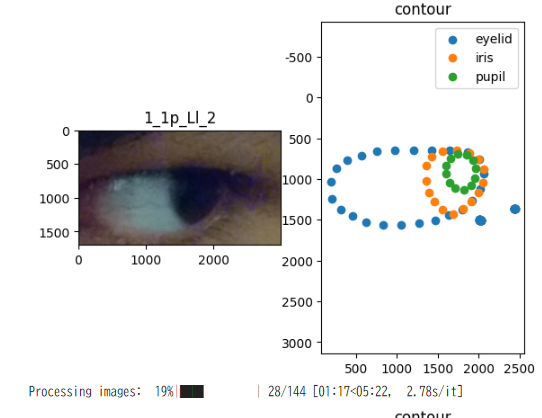

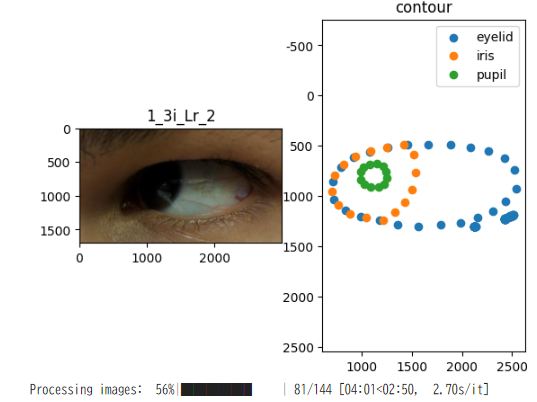

## 確認用のコード

しかし、以下のコードでもう一度プロットしてみると問題ないです…なぜ

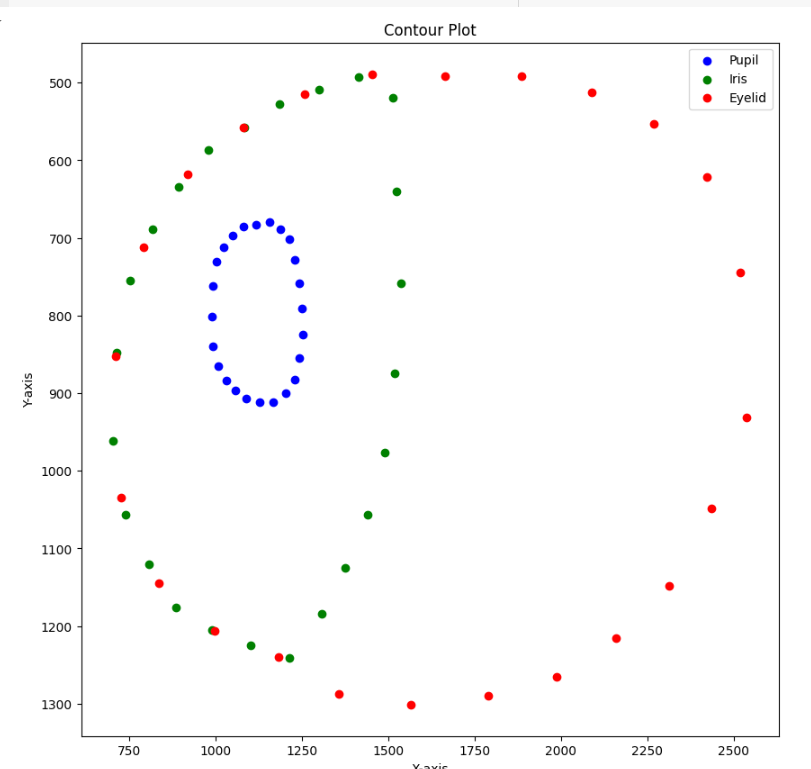

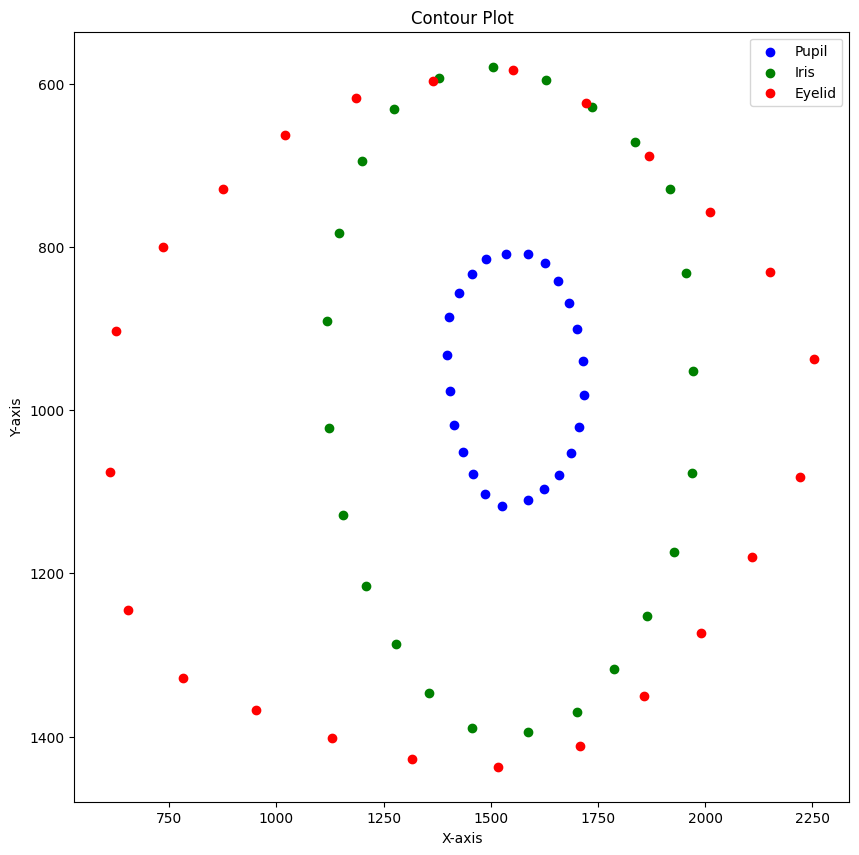

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Define functions for processing
def create_mask(image, color):
    return np.all(image == color, axis=-1)

def apply_mask(image, mask):
    return np.where(mask, 255, 0)

def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list

# Load the image to debug
mask_file = "/content/drive/MyDrive/Deep_learning/Eyelid_segmentation/MOBIUS/Masks/1/1_3i_Ls_1.png"
img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
img_height, img_width = img.shape[:2]

# Define color masks
mask_blue = create_mask(img, [255, 0, 0])
mask_green = create_mask(img, [0, 255, 0])
mask_red = create_mask(img, [0, 0, 255])

# Combine masks for different regions
mask_blue_green = np.logical_or(mask_blue, mask_green)
mask_all_colors = np.logical_or(mask_blue_green, mask_red)

# Apply masks
img_blue = apply_mask(img, mask_blue)
img_blue_green = apply_mask(img, mask_blue_green)
img_all_colors = apply_mask(img, mask_all_colors)

# Extract contours
num_points = 24  # Default number of points
points_list_blue = extract_contours(img_blue, num_points)
points_list_blue_green = extract_contours(img_blue_green, num_points)
points_list_all_colors = extract_contours(img_all_colors, num_points)

# Plot points on coordinate plane
plt.figure(figsize=(10, 10))

# Plot blue (pupil)
if points_list_blue:
    x_blue = [point[0] for point in points_list_blue[0]]
    y_blue = [point[1] for point in points_list_blue[0]]
    plt.scatter(x_blue, y_blue, color='blue', label='Pupil')

# Plot blue_green (iris)
if points_list_blue_green:
    x_blue_green = [point[0] for point in points_list_blue_green[0]]
    y_blue_green = [point[1] for point in points_list_blue_green[0]]
    plt.scatter(x_blue_green, y_blue_green, color='green', label='Iris')

# Plot all_colors (eyelid)
if points_list_all_colors:
    x_all_colors = [point[0] for point in points_list_all_colors[0]]
    y_all_colors = [point[1] for point in points_list_all_colors[0]]
    plt.scatter(x_all_colors, y_all_colors, color='red', label='Eyelid')

# Adjust plot
plt.title("Contour Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates
plt.legend()

# Show plot
plt.show()


## [試作品段階のコード](https://colab.research.google.com/drive/16fyns7E-PEstRELygVeMyLE5gbmVhyPe#scrollTo=NYNAK-r12mPz)

念のために共有します。